In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})

def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=False)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=False)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model

def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 4,
           structurePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True,
              penalty = 100)
    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)

def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = df[key]
    return retval
num_models = 100       
pc = pc()
pc.start_vm(java_max_heap_size = '21000M')
tetrad = s.tetradrunner()

inputs = ['Sex', 'Equipment', 'Age',  'Deadlift1Kg', 'Bench1Kg']
#inputs = ['gender', 'race', 'lunch', 'test_preparation_course', 'education']#, 'math_score', 'writing_score']
target = ['Squat1Kg']
categoricals = ['Sex', 'Equipment'] 

/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('~/Desktop/Kaggle/openpowerlifting.csv')
df = df[['Sex', 'Equipment', 'Age', 'Squat1Kg', 'Deadlift1Kg', 'Bench1Kg']]

/home/tkyono/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)

In [4]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder_list = []
#one_hot = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for i,col in enumerate(categoricals):
    label_encoder_list.append(LabelEncoder())
    df[col] = label_encoder_list[i].fit_transform(df[col].values)

In [5]:
df = df[(df['Bench1Kg'] > 0) & (df['Squat1Kg'] > 0) & (df['Deadlift1Kg'] > 0) ]
df.reset_index(drop = True, inplace = True)

In [6]:
def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))
df['Age'] = normalize(df['Age'])
df['Squat1Kg'] = normalize(df['Squat1Kg'])
df['Deadlift1Kg'] = normalize(df['Deadlift1Kg'])
df['Bench1Kg'] = normalize(df['Bench1Kg'])
#df['TotalKg'] = normalize(df['TotalKg'])

[[2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024

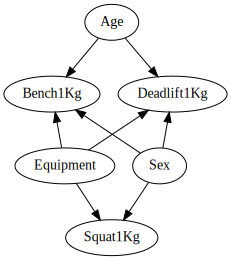

In [11]:
import pydot
from IPython.display import SVG
def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def examine_graph_mixed(df, prior = None):
    #tetrad.run(algoId = 'gfci', dfs = df, testId = 'cond-gauss-lrt', scoreId = 'cond-gauss-bic', 
    #       priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 5,
    #       structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 5,
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)

    return tetrad.getTetradGraph()

def examine_graph_discrete(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'bdeu', priorKnowledge = prior, dataType = 'discrete',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()
    
    

tempForbid = p.ForbiddenWithin(['Sex', 'Age', 'Equipment'])
temporal = [tempForbid, p.ForbiddenWithin(['Squat1Kg',  'Deadlift1Kg', 'Bench1Kg'])]
prior = p.knowledge( addtemporal = temporal)

g = examine_graph_mixed(df[inputs + target], prior = prior)
dot_str = pc.tetradGraphToDot(g)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()

known_conx = set({})
for i in tetrad.getEdges():
    if ' --> ' in i:
        known_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
known_conx

prior = p.knowledge(addtemporal = temporal, requiredirect =  list(map(list, known_conx)),)
models = []
model_names = []



randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/random' + str(i))
    print(models, model_names)    
else:
    model_layers = [2048,1024,512]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/pl' + str(i))

print(models, model_names)

SVG(svg_str)



In [12]:
#known_conx.add(('Age', 'Squat1Kg')), known_conx

In [13]:
prior = p.knowledge(addtemporal = temporal, requiredirect =  list(map(list, known_conx)),)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

1*  Age Equipment Sex
2*  Bench1Kg Deadlift1Kg Squat1Kg

forbiddirect

requiredirect
Age Bench1Kg
Equipment Bench1Kg
Equipment Squat1Kg
Age Deadlift1Kg
Sex Deadlift1Kg
Sex Bench1Kg
Sex Squat1Kg
Equipment Deadlift1Kg

In [14]:

bestMSE = []
bestBIC = []
bestCOMBO = []
original_df = df.copy()

for t in range(50):
    # let's split our df into two by race.  Let's see what happens if we 
    df = original_df[:20000].copy()
    
    holdout = 3000
        #df_test = df[df['charges'] > 0.54].copy()
    continuous = ['Age', 'Squat1Kg',  'Deadlift1Kg', 'Bench1Kg']
    #continuous = ["math_score"]
    
    '''
    end_idx = len(df) - holdout
    cont = random.randint(0, len(continuous) - 1)
    start_idx = random.randint(0, end_idx)
    print(t, "Doing range:",start_idx, start_idx + holdout, "and ", continuous[cont])
    df_test = df.nlargest(len(df) - start_idx, continuous[cont]).nsmallest(holdout, continuous[cont])
    '''

    small = random.randint(0,1)
    cont = random.randint(0, len(continuous) - 1)
    if small == 0:
        df_test = df.nsmallest(holdout, continuous[cont])
    else:
        df_test = df.nlargest(holdout, continuous[cont])
    print(t, small, continuous[cont])

    

    df.drop(df_test.index, inplace = True)
    df_test.reset_index(inplace = True)
    df.sample(frac= 1).reset_index(inplace = True) # this will shuffle and reset index

    x_test = df_test[inputs]
    y_test = df_test[target]

    causal_split = 0.2
    val_split = 0.2
    train_split = 1 - (causal_split + val_split)

    x_causal = df[inputs][-int(causal_split * len(df)) :]
    y_causal = df[target][-int(causal_split * len(df)) :]

    x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
    y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]

    x_train = df[inputs][:int(train_split * len(df))]
    y_train = df[target][:int(train_split * len(df))]

    x_test_NN = make_categorical(x_test, original_df, categoricals)
    x_causal_NN = make_categorical(x_causal, original_df, categoricals)
    x_val_NN = make_categorical(x_val, original_df, categoricals)
    x_train_NN = make_categorical(x_train, original_df, categoricals)
    verbosity = 0

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            #clear session
            keras.backend.clear_session() 
            #get model according to specification
            model = get_model(models[idx], [0.2] * len(models), np.shape(x_train_NN)[1])
            callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                         EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
            model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
            #print(len(X), len(y))
            model.fit(x_train_NN, y_train, epochs = 20, validation_data = (x_val_NN, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
        else:
            models[idx].fit(X,y)





    generalization = []
    metrics = []
    proposed = []
    x_causal.reset_index(drop = True, inplace = True)

    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(x_test_NN)
        generalization.append(mean_squared_error(y_pred, y_test))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal_NN)
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)



        metrics.append(mean_squared_error(y_causal_pred, y_causal))
        #print(x_causal.head)
        bic_pred = get_bic(causal_df, prior)
        #print(bic_pred, tetrad.getEdges())

        found_conx = set({})
        for i in tetrad.getEdges():
            if ' --> ' in i:
                found_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
        found_conx

        if found_conx == known_conx:
            proposed.append(bic_pred)
        else:
            print("******Found an error")
            print(bic_pred, tetrad.getEdges())
            # for now just remove bad model.  Will need to add it to distance metric.
            proposed.append(bic_pred)
            #metrics = metrics[:-1]
            #generalization = generalization[:-1]
    nbest = 10
    total = normalize(metrics) + normalize(proposed)
    final = pd.DataFrame(np.stack((metrics, proposed, total, normalize(generalization)), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization']))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization']))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization']))
    bestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'])
    bestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'])
    bestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'])
np.mean(bestMSE), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

0 0 Bench1Kg
MSE =  3.4652521666851674
BIC =  3.8273730790069136
COMB =  3.030112239161065
1 0 Squat1Kg
******Found an error
14793.092540349602 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg']
MSE =  2.2119078718916714
BIC =  2.0071761614947707
COMB =  2.1483257777110336
2 1 Age
******Found an error
15051.228595863255 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
15122.901804159696 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
15142.85335771245 ['Age --> Bench1Kg', 'Equi

******Found an error
15181.641568219615 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg']
******Found an error
15106.315095937694 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Bench1Kg']
******Found an error
15328.12117198445 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Sex --> Bench1Kg']
******Found an error
14859.64471551003 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Foun

******Found an error
15148.3431751887 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14816.587236390691 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
15206.903386091806 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14949.024273766761 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Foun

MSE =  4.918590119221009
BIC =  3.644237883287732
COMB =  4.154996498449711
4 1 Deadlift1Kg
******Found an error
13962.659907805746 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
13940.985808441317 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
13872.964604103596 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
13714.654344381557 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex 

******Found an error
14057.143364737814 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg']
******Found an error
14006.519439458472 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
13953.880584798502 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
13709.478073326529 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Fo

******Found an error
14614.683774235958 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Found an error
14439.754385876513 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14391.325993699951 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
14436.829106629993 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg']
******Fo

******Found an error
14446.26618444459 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Found an error
14298.578295572092 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14427.737212678112 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg']
******Found an error
14374.199115740152 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Fou

******Found an error
14152.136957680668 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
14390.991539284312 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg']
******Found an error
14313.770793753467 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14229.722239784322 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Fo

******Found an error
10885.587037245885 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
10950.13144756799 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
10927.456442985418 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
10934.770417348185 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg']
******Fou

******Found an error
10843.77364076683 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
10839.842749010135 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg']
******Found an error
10939.41973237956 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Found an error
10827.193756480625 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Sex --> Bench1Kg']
******Foun

******Found an error
11059.943080091623 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
10931.703604828526 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
11124.649772182762 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
10812.274859228502 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Fo

******Found an error
14438.25745455972 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14453.460905535372 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg']
******Found an error
14155.049283934424 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
14551.165942178002 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Fou

******Found an error
10821.001043588396 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
11263.07830811727 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
10994.177163478094 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
10956.132324556143 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg']
******Fou

******Found an error
10817.345796362855 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
11090.740324291775 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
10757.915562689046 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
10972.003582769124 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Fo

******Found an error
11070.92735289034 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg']
******Found an error
10929.013349305105 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
10842.818463563664 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
10964.437419383068 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Fou

******Found an error
13847.428682172602 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
13952.480416257908 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
13649.242468566945 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14104.080275116712 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg']
******Fo

******Found an error
13605.866382137652 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14164.1868560282 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
13931.776683185224 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg']
******Found an error
13907.90670372599 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Squat1Kg']
******Found

******Found an error
14493.758949073483 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14741.323640203622 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14631.959502471671 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
14912.516920082813 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Fo

******Found an error
14567.696152490656 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
14463.699258284814 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14109.917232095318 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14557.120467091838 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Fo

******Found an error
14276.673605283067 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14493.491754338103 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14494.478265250696 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg']
******Found an error
14611.6939422456 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Foun

******Found an error
14281.239309302788 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14301.83258368806 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14458.750643964444 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14402.389547420937 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Fou

******Found an error
13903.809000818506 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
13995.477092405683 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14184.79769593108 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
13942.539754453155 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Fou

******Found an error
13778.694407029408 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14282.121045995991 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
13962.312272963252 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg']
******Found an error
13787.759396071715 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Fo

******Found an error
11063.21958244979 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg']
******Found an error
10790.183060627529 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
11007.912494369572 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
10940.760856931509 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg']
******Fou

******Found an error
10969.127608566967 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
10908.548183805524 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
10935.371497820253 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg']
******Found an error
10828.452192229606 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Fo

******Found an error
11017.677539579785 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
11008.909362144175 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg']
******Found an error
10944.143997428895 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
10837.379891628134 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg']
******Fo

******Found an error
14404.009709266016 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14416.751767944234 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14501.180328675679 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14363.80323890625 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg']
******Fou

******Found an error
14791.717965966003 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Found an error
14360.649504036128 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14402.19536577209 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14500.531392455156 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Fou

******Found an error
14584.334629997937 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg']
******Found an error
14225.536045709903 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14212.743534699724 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg']
******Found an error
14461.668452191992 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
MSE =  1

******Found an error
14570.927169340188 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg']
******Found an error
14452.573875055068 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
14580.738259131142 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14601.92509929289 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Fou

******Found an error
14507.842124284376 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14480.159514770688 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14141.733938803878 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14492.40642932461 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg']
******Fou

******Found an error
14248.393608920185 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14381.112355708594 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14144.533633214553 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg']
******Found an error
14222.300648114815 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Fo

******Found an error
14697.387320584075 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg']
******Found an error
14152.282076503046 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14501.525976670477 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Found an error
14506.871491253012 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg']
******Fo

******Found an error
15009.761122629325 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14883.772949248847 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
15199.173731098354 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg']
******Found an error
15066.481878916273 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg']
******Fo

******Found an error
15058.503045314505 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
14970.281770451034 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
15051.652229931278 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg']
******Found an error
15163.561188083317 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg']
******Fo

******Found an error
15086.501769865245 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
15195.418941515563 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
15057.743634816707 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
15122.736226846235 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Fo

******Found an error
14272.312447772747 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14334.904510352908 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg']
******Found an error
14347.231251402982 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14792.948025768921 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Fo

******Found an error
14331.73562457307 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg']
******Found an error
14647.93807762635 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14453.071705167651 ['Age --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Bench1Kg']
******Found an error
14297.534818158445 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Foun

******Found an error
14530.5802761742 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14567.236461266648 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
14407.565159840777 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
14396.351459405394 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg']
******Foun

******Found an error
14551.97620142899 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14367.064378984807 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14612.688724776515 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
14396.143213567902 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Fou

******Found an error
14782.816121458267 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
14355.530785522695 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg']
******Found an error
14522.209044744382 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg']
******Found an error
14342.946857655706 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg']
******Fo

******Found an error
14452.921121245467 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Bench1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14131.186703090136 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14600.399645424995 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Found an error
14316.247892949788 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg']
******Fo

******Found an error
14705.69789324905 ['Age --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
******Found an error
14214.69456515903 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg']
MSE =  0.9783602522510335
BIC =  0.7139749611123186
COMB =  0.70322318191377
23 1 Bench1Kg
******Found an error
14599.705821267935 ['Age --> Bench1Kg', 'Sex --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14515.277163564613 ['Age --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age -->

******Found an error
14159.193742596139 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg', 'Equipment --> Squat1Kg']
******Found an error
14316.224816541246 ['Age --> Bench1Kg', 'Equipment --> Deadlift1Kg', 'Age --> Deadlift1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Age --> Squat1Kg', 'Equipment --> Bench1Kg', 'Equipment --> Squat1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14270.717997817475 ['Age --> Bench1Kg', 'Equipment --> Squat1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Equipment --> Bench1Kg', 'Sex --> Deadlift1Kg']
******Found an error
14395.740098186809 ['Age --> Bench1Kg', 'Equipment --> Bench1Kg', 'Age --> Deadlift1Kg', 'Age --> Squat1Kg', 'Equipment --> Deadlift1Kg', 'Sex --> Squat1Kg', 'Equipment --> Squat1Kg', 'Sex --> Bench1Kg', 'Sex --> Deadlift1Kg']
MSE =  0

KeyboardInterrupt: 

In [15]:
def get_average_improvement(df1, df2):
    ret = []
    for i, j in zip(df1,df2):
        ret.append(np.sum(j.values - i.values))
    return ret

improvement = get_average_improvement(bestMSE, bestCOMBO)
np.mean(improvement), np.std(improvement)

(-0.20105758043498786, 0.229656989258956)

In [16]:
np.mean(bestMSE), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

(0.17037642797697422,
 0.1502706699334754,
 0.13294694285391634,
 0.12307339892811547)

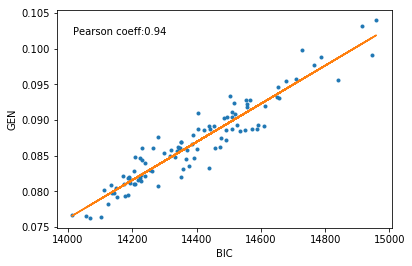

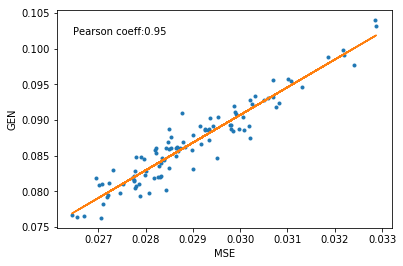

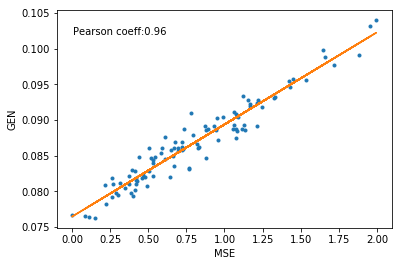

In [13]:
fig, ax = plt.subplots()
b,m = polyfit(proposed,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(proposed,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(proposed,generalization, '.')
plt.plot(proposed, b + m * np.array(proposed), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(metrics,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(metrics,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(metrics,generalization, '.')
plt.plot(metrics, b + m * np.array(metrics), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


total = normalize(metrics) + normalize(proposed)
fig, ax = plt.subplots()
b,m = polyfit(total,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(total,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(total,generalization, '.')
plt.plot(total, b + m * np.array(total), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


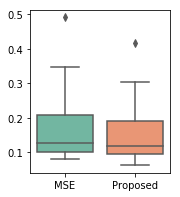

In [17]:
import seaborn as sns
val1 = []
for each in bestMSE:
    val1.append(np.mean(each))
val2 = []
for each in bestCOMBO:
    val2.append(np.mean(each))

val = []
for x, y in zip(val1, val2):
    val.append([x, y])
    
fig, ax = plt.subplots()
fig.set_size_inches(2.5,3)
df = pd.DataFrame(val, columns = ['MSE', 'Proposed'])
ax = sns.boxplot(ax = ax, data=df, palette="Set2")
fig.savefig('kaggle-bikeshare.pdf')
d = dict()
d['bestMSE'] = bestMSE
d['bestCOMBO'] = bestCOMBO


import pickle

with open('Powerlifting.pkl', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
nbest = 10
final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization']))
print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization']))
print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization']))

MSE =  0.7865421842495053
BIC =  0.7852053566816717
COMB =  0.7868056817083808
